In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
genres = os.listdir("../data/genres_original")
genres.sort()

In [3]:
genre_file_counts = {}
total_files = 0

for genre in genres:
    genre_path = os.path.join("../data/genres_original", genre)
    
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    count = len(files)  
    genre_file_counts[genre] = count
    total_files += count
    
    print(f"{genre:15} : {count:3} files")


blues           : 100 files
classical       : 100 files
country         : 100 files
disco           : 100 files
hiphop          : 100 files
jazz            : 100 files
metal           : 100 files
pop             : 100 files
reggae          : 100 files
rock            : 100 files


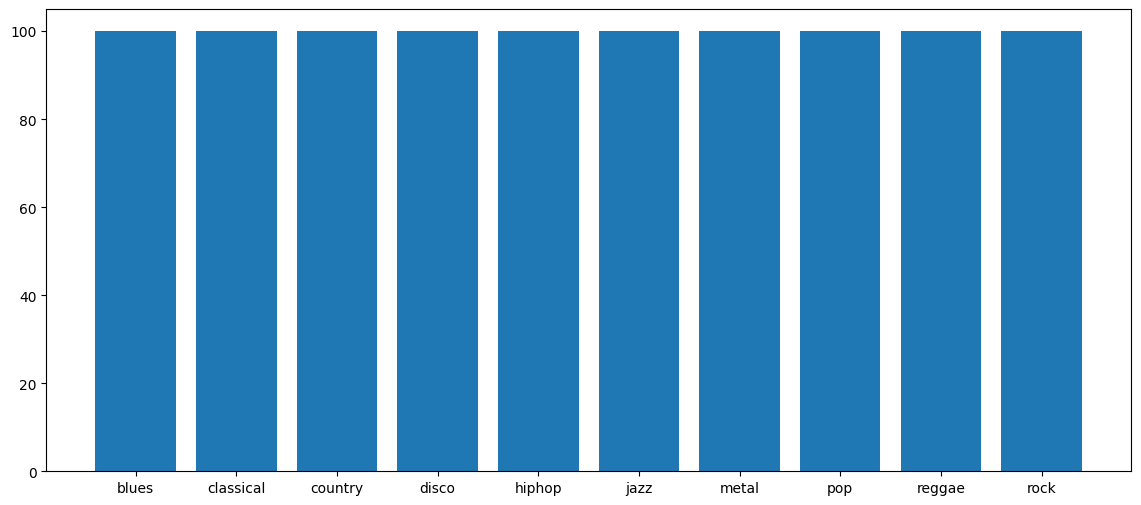

In [4]:
plt.figure(figsize=(14, 6))  # increase width
plt.bar(
    genre_file_counts.keys(),      # X values (genre names)
    genre_file_counts.values(),
)
plt.savefig("../results/plots/distribution.png")

In [37]:
audio_properties = []
for genre in genres:
    c = 0
    genre_path = os.path.join(f"../data/genres_original/{genre}")
    files=  []
    for f in os.listdir(genre_path):
        c+=1
        if c >= 6:
            break 
        files.append(f) 

    for file  in files:
        file_path = os.path.join(genre_path, file)
        wave_form , sample_rate = librosa.load(file_path)
        n_samples = len(wave_form)
        duration = librosa.get_duration(y=wave_form, sr=sample_rate)
        audio_properties.append({
                'genre': genre,
                'filename': file,
                'duration_sec': duration,
                'sample_rate': sample_rate,
                'n_samples': n_samples,
                'min_amplitude': np.min(wave_form),      # Quietest point
                'max_amplitude': np.max(wave_form),      # Loudest point
                'mean_amplitude': np.mean(np.abs(wave_form)),  # Average loudness
                'std_amplitude': np.std(wave_form)       # Variation in loudness
        })

df = pd.DataFrame(audio_properties)



In [45]:
genre_amplitudes = df.groupby('genre').agg({
    'mean_amplitude': 'mean',
    'max_amplitude': 'mean',
    'min_amplitude': 'mean'
}).reset_index()
genre_amplitudes

,genre,mean_amplitude,max_amplitude,min_amplitude
0,blues,0.101078,0.821887,-0.797583
1,classical,0.029532,0.283643,-0.270801
2,country,0.171152,0.724799,-0.728058
3,disco,0.125503,0.801465,-0.816302
4,hiphop,0.154455,0.908295,-0.927496
5,jazz,0.051291,0.590051,-0.521466
6,metal,0.089151,0.604681,-0.591412
7,pop,0.160675,0.950067,-0.968048
8,reggae,0.072151,0.813483,-0.759119
9,rock,0.129273,0.967914,-0.970813


C:\Users\plana\AppData\Local\Temp\ipykernel_16688\4280852870.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='genre', y='mean_amplitude', palette='Set2')


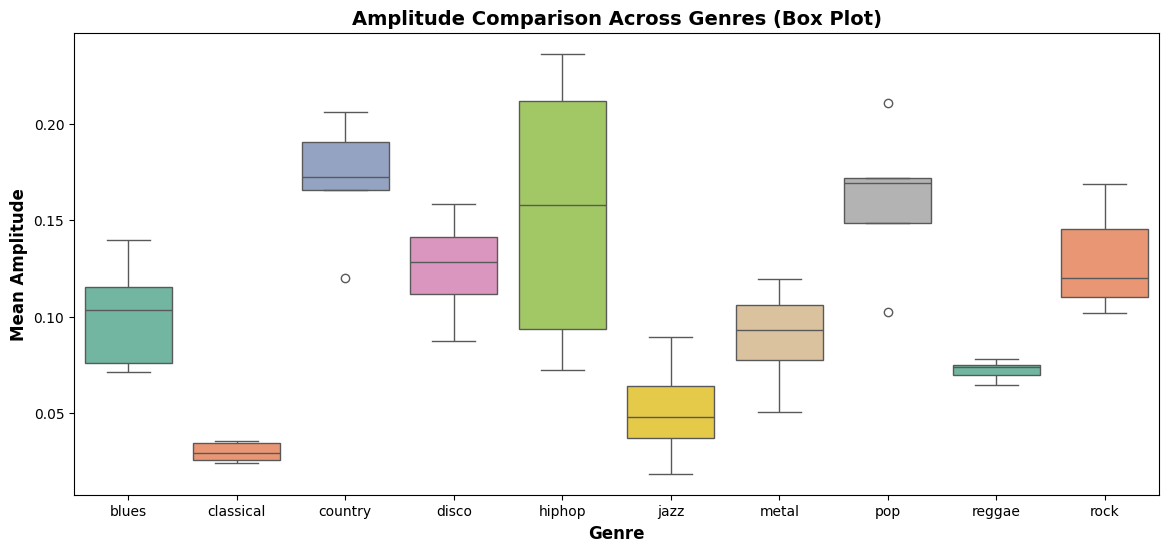

In [51]:
plt.figure(figsize=(14, 6))

sns.boxplot(data=df, x='genre', y='mean_amplitude', palette='Set2')

plt.xlabel('Genre', fontsize=12, fontweight='bold')
plt.ylabel('Mean Amplitude', fontsize=12, fontweight='bold')
plt.title('Amplitude Comparison Across Genres (Box Plot)', fontsize=14, fontweight='bold')
plt.savefig("../results/plots/amplitude_boxplot.png", dpi=300)


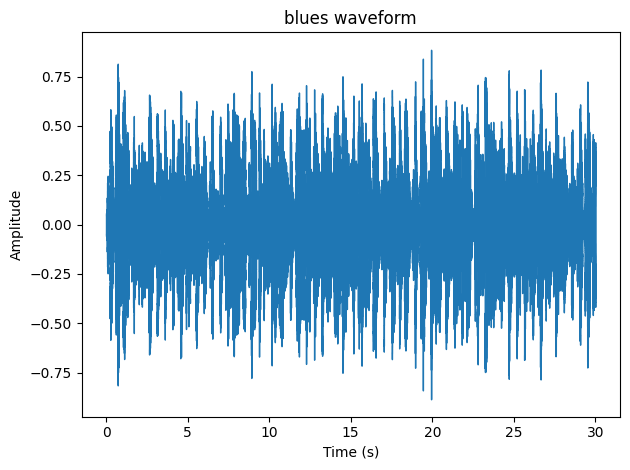

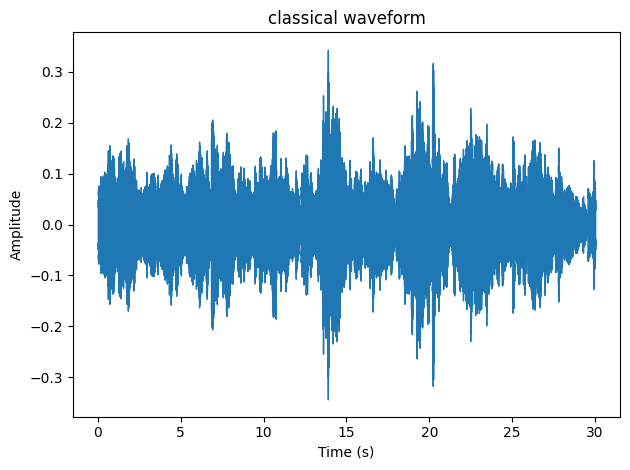

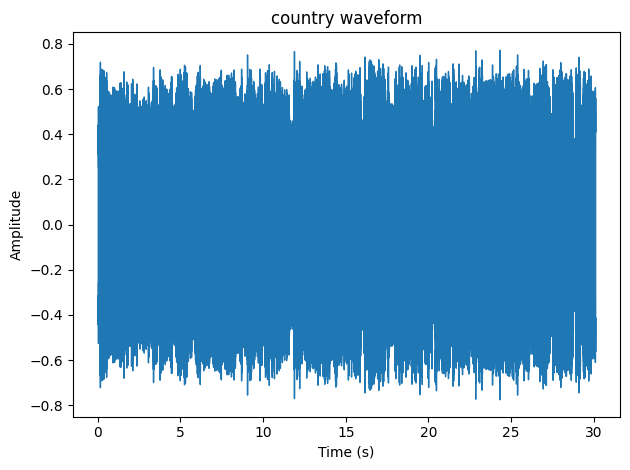

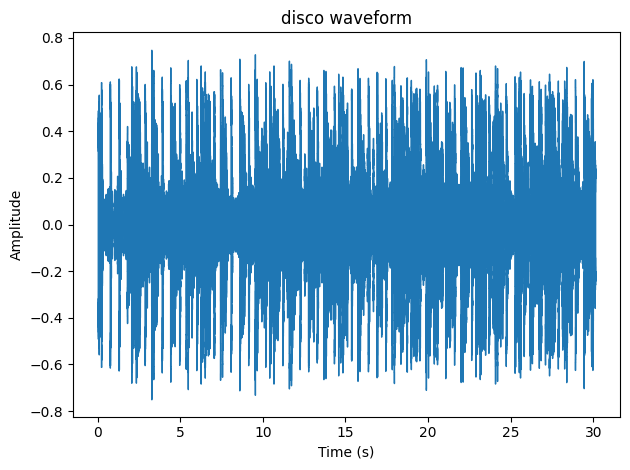

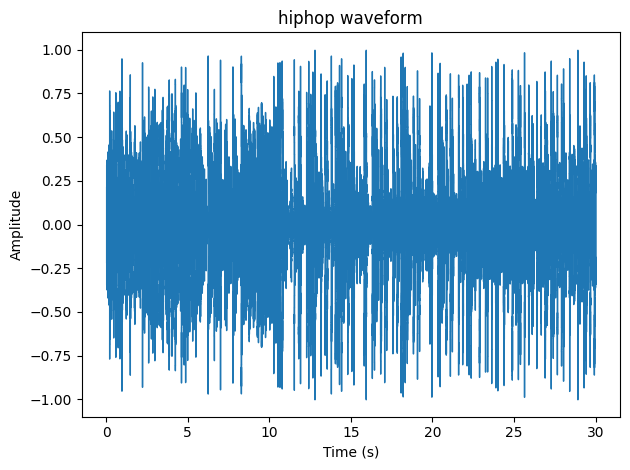

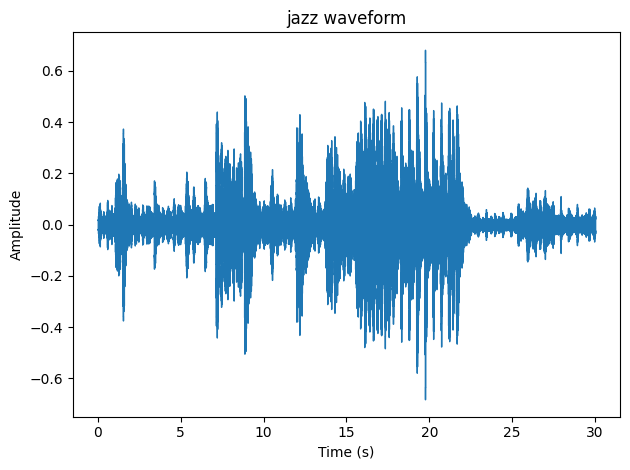

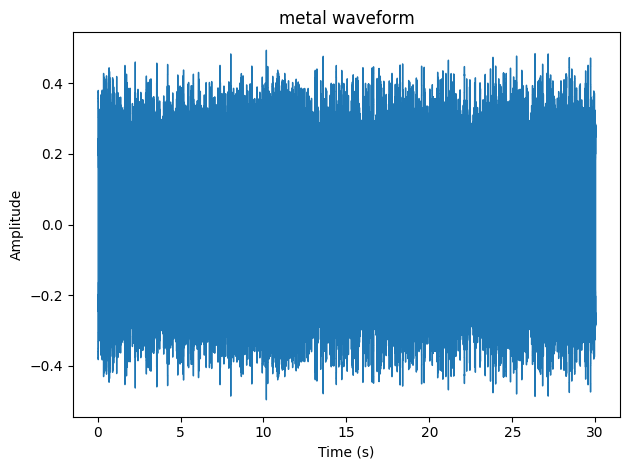

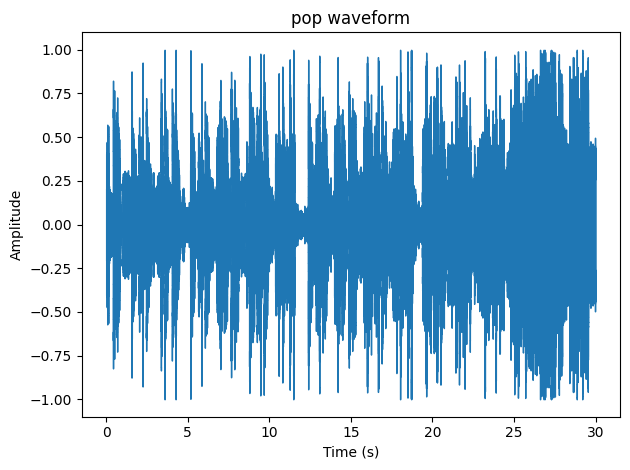

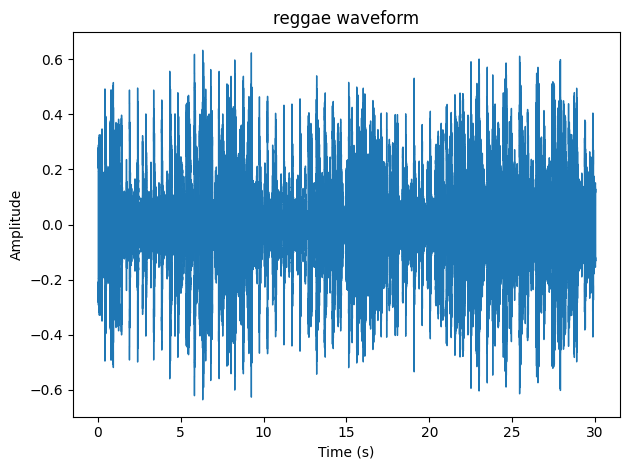

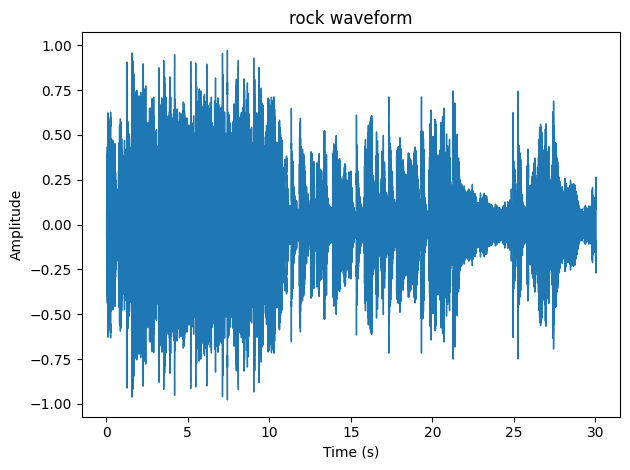

<Figure size 640x480 with 0 Axes>

In [50]:
for genre in genres:
    c = 0
    genre_path = os.path.join(f"../data/genres_original/{genre}")
    files=  []
    for f in os.listdir(genre_path):
        c+=1
        if c >= 2:
            break 
        files.append(f) 

    for file  in files:
        file_path = os.path.join(genre_path, file)
        wave_form , sample_rate = librosa.load(file_path)
        librosa.display.waveshow(wave_form,sr=sample_rate)
        plt.title(f"{genre} waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"../results/plots/{genre}_waveform.png", dpi=300)


In [52]:
def extract_features(file_path):
        y, sr = librosa.load(file_path, duration=30)
        features = {}
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) #Mel-frequency Cepstral Coefficients
        for i in range(13):
            features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i}_std'] = np.std(mfccs[i])

        # Spectral Centroids
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['rolloff_mean'] = np.mean(rolloff)
        features['rolloff_std'] = np.std(rolloff)

        # Zero Crossing Rate 
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)

        # Chroma (harmony)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(12):
            features[f'chroma_{i}_mean'] = np.mean(chroma[i])
    
        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        # RMS Energy (loudness)
        rms = librosa.feature.rms(y=y)[0]
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)

        return features

In [54]:

all_features = []
file_count = 0

for genre in genres:
    print(f"\nProcessing genre: {genre}")
    genre_path = os.path.join("../data/genres_original", genre)
    
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    
    for i, file in enumerate(files):
        file_path = os.path.join(genre_path, file)
        
        try:
            features = extract_features(file_path)
                
            features['genre'] = genre
            features['filename'] = file
            
            all_features.append(features)
            
            file_count += 1
            
            if (i + 1) % 10 == 0:
                print(f"  Processed {i + 1}/{len(files)} files...")
                
        except Exception as e:
            print(f"  Error with {file}: {e}")


print(f"Feature extraction complete!")
print(f"Processed {file_count} files")

df_features = pd.DataFrame(all_features)

df_features.to_csv('../data/features.csv', index=False)



Processing genre: blues
  Processed 10/100 files...
  Processed 20/100 files...
  Processed 30/100 files...
  Processed 40/100 files...
  Processed 50/100 files...
  Processed 60/100 files...
  Processed 70/100 files...
  Processed 80/100 files...
  Processed 90/100 files...
  Processed 100/100 files...

Processing genre: classical
  Processed 10/100 files...
  Processed 20/100 files...
  Processed 30/100 files...
  Processed 40/100 files...
  Processed 50/100 files...
  Processed 60/100 files...
  Processed 70/100 files...
  Processed 80/100 files...
  Processed 90/100 files...
  Processed 100/100 files...

Processing genre: country
  Processed 10/100 files...
  Processed 20/100 files...
  Processed 30/100 files...
  Processed 40/100 files...
  Processed 50/100 files...
  Processed 60/100 files...
  Processed 70/100 files...
  Processed 80/100 files...
  Processed 90/100 files...
  Processed 100/100 files...

Processing genre: disco
  Processed 10/100 files...
  Processed 20/100 file

C:\Users\plana\AppData\Local\Temp\ipykernel_16688\3451759158.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
c:\Users\plana\Documents\Music_Genre_Classification\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Error with jazz.00054.wav: 
  Processed 60/100 files...
  Processed 70/100 files...
  Processed 80/100 files...
  Processed 90/100 files...
  Processed 100/100 files...

Processing genre: metal
  Processed 10/100 files...
  Processed 20/100 files...
  Processed 30/100 files...
  Processed 40/100 files...
  Processed 50/100 files...
  Processed 60/100 files...
  Processed 70/100 files...
  Processed 80/100 files...
  Processed 90/100 files...
  Processed 100/100 files...

Processing genre: pop
  Processed 10/100 files...
  Processed 20/100 files...
  Processed 30/100 files...
  Processed 40/100 files...
  Processed 50/100 files...
  Processed 60/100 files...
  Processed 70/100 files...
  Processed 80/100 files...
  Processed 90/100 files...
  Processed 100/100 files...

Processing genre: reggae
  Processed 10/100 files...
  Processed 20/100 files...
  Processed 30/100 files...
  Processed 40/100 files...
  Processed 50/100 files...
  Processed 60/100 files...
  Processed 70/100 files.